## Machine Learning Modeling

This notebook intents to create machine learning models for predicting Samambaia house prices. Specifically, we're interested in regression models, and even further, stacked regressions.

This notebook uses <a target='_blank' href='https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard'>this kaggle notebook</a> as a reference.

The feeature engineering processes we'll be:
* Inputing missing values;
* Transforming numerical data that looks like categorical;
* Label enconding categorical variables;
* Transform non-normal data to normal shape (skewed data to normal distribution);
* Get dummy variables for categorial columns.

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from subprocess import check_output
#check the files available in the directory
print(check_output(["ls", "./data"]).decode("utf8"))

houses.xlsx
new_data.csv
processed_data.csv
samambaia_houses.csv
test.csv
teste.xlsx
train.csv



In [120]:
# Import the train and test datasets in pandas dataframe
train_df = pd.read_csv('./data/train.csv', index_col=[0])
test_df = pd.read_csv('./data/test.csv', index_col=[0])

In [121]:
# Display the first five rows of the train dataset
train_df.head(5)

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_hyperlink,house_category,n_bathrooms,zip_code,street_address,metro_distance
1649,335000.000,Sul,2,Com condomínio,0.000,Com garagem,1,50.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,2,72300533.000,Quadra 301 Conjunto 2,3
2761,440000.000,Norte,3,Com condomínio,0.000,Com garagem,1,119.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,2,72318210.000,QR 406 Conjunto 9-A,2
223,290000.000,Norte,3,Com condomínio,385.000,Com garagem,1,NaN,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,2,72318230.000,QR 406 Conjunto 28,2
106,210000.000,Norte,3,Com condomínio,0.000,Com garagem,1,112.000,https://df.olx.com.br/distrito-federal-e-regia...,Casas,3,72322505.000,QS 602 Conjunto E Comércio,3
2541,183000.000,Norte,2,Com condomínio,0.000,Com garagem,1,33.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,1,72321000.000,QR 407,3


In [122]:
# Display the first five rows of the test dataset
test_df.head(5)

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_hyperlink,house_category,n_bathrooms,zip_code,street_address,metro_distance
487,120008.000,Sul,2,Com condomínio,260.000,Com garagem,1,47.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,1,72302203.000,QR 108 Conjunto 3,1
2770,294900.000,Norte,2,Com condomínio,0.000,Com garagem,2,120.000,https://df.olx.com.br/distrito-federal-e-regia...,NaN,NaN,NaN,NaN,3
134,200000.000,Sul,3,Sem condomínio,0.000,Sem garagem,0,NaN,https://df.olx.com.br/distrito-federal-e-regia...,Casas,2,72301700.000,QR 115,3
1057,420000.000,Norte,4,Com condomínio,1.000,Com garagem,3,112.000,https://df.olx.com.br/distrito-federal-e-regia...,Casas,2,72318112.000,QR 404 Conjunto 11,2
454,209000.000,Sul,2,Com condomínio,0.000,Com garagem,1,42.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,1,72310000.000,QN 320,3


In [123]:
# Check the number of samples and features
print(f'The train data size before dropping Hyperlink feature is {train_df.shape}')
print(f'The test data size before dropping Hyperlink feature is {test_df.shape}')

train_hyperlink = train_df['house_hyperlink']
test_hyperlink = test_df['house_hyperlink']

# Now drop the 'house_hyperlink' column since it's unnecessary for the prediction process.
train_df.drop('house_hyperlink', axis = 1, inplace = True)
test_df.drop('house_hyperlink', axis = 1, inplace = True)

# Check again the data size after droping the 'house_hyperlink' column
print(f'\nThe train data size after dropping Hyperlink feature is {train_df.shape}')
print(f'The test data size after dropping Hyperlink feature is {test_df.shape}')

The train data size before dropping Hyperlink feature is (1991, 14)
The test data size before dropping Hyperlink feature is (854, 14)

The train data size after dropping Hyperlink feature is (1991, 13)
The test data size after dropping Hyperlink feature is (854, 13)


### Data Processing

#### Outliers

We've seen in the previous notebook, in the data analysis, that one appartment in specific had huge size and low price. Let's see the data again:

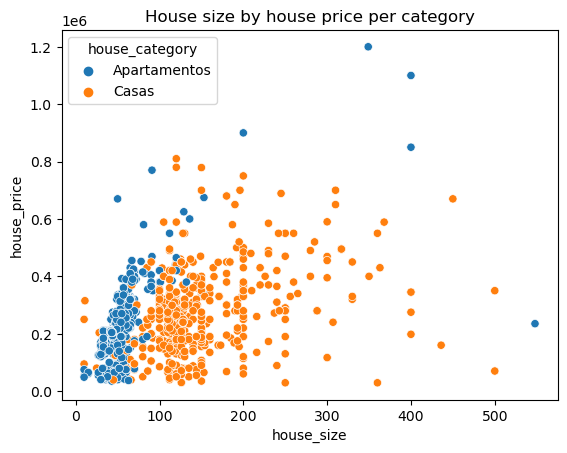

In [124]:
sns.scatterplot(
    data=train_df, 
    x = train_df['house_size'], 
    y = train_df['house_price'],
    hue=train_df['house_category'])

plt.title('House size by house price per category')
plt.show()

Apartamentos are apartments and Casas are houses, in portuguese. See we have a blue dot showing a large apartment that seems not common. We'll remove that and plot it again.

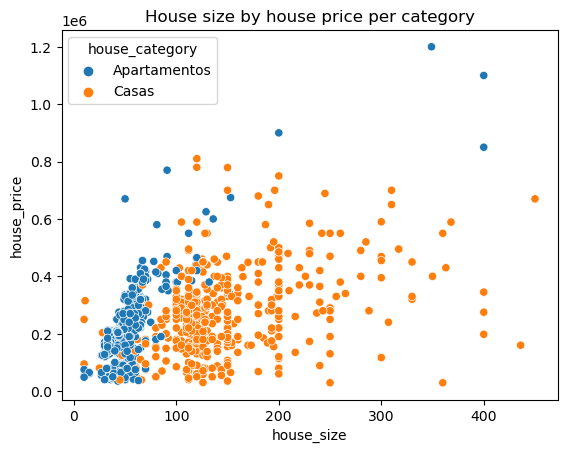

In [125]:
# Drop that specific blue point by defining these conditions
train_df = train_df\
            .drop(train_df[(train_df['house_size'] >= 500) & (train_df['house_price'] < 400000)].index)

# Check the points again
sns.scatterplot(
    data=train_df, 
    x = train_df['house_size'], 
    y = train_df['house_price'],
    hue=train_df['house_category'])

plt.title('House size by house price per category')
plt.show()

Note: As the reference book says, it's a delicate thing to just remove outliers. This is because we might delete important data and this might affect badly our models, as it might not be good at the test and the real data we could try to predict. So, instead of just removing all outliers, it's good practice to just deal with them and make robust models. Anyway, we just removed one outliers and we'll deal with others left in this training dataset.

### Target variable

house_price is the target variable we want to predict. Let's just take a look at it quickly:


 mu = 234987.07 and sigma = 118337.05


/home/bombadil/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


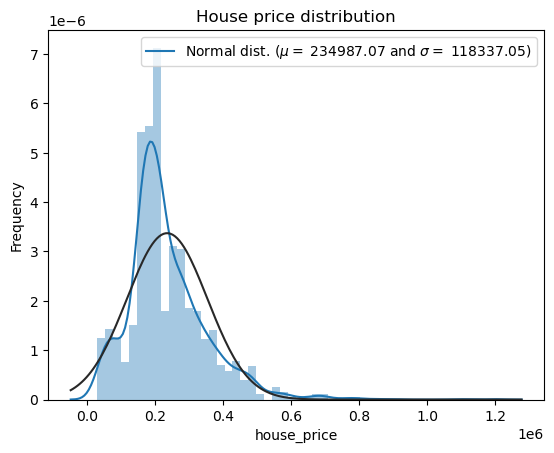

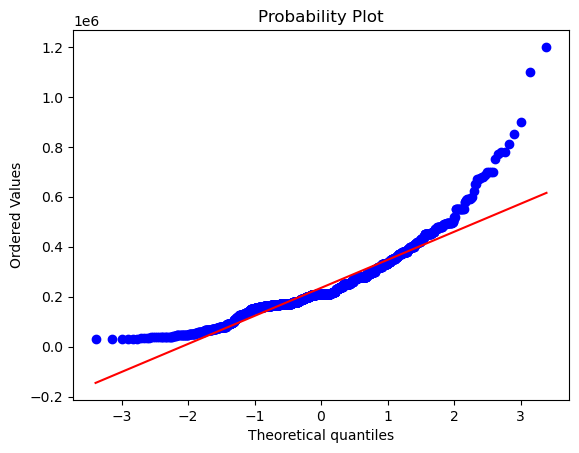

In [126]:
from scipy.stats import norm, skew
from scipy import stats

sns.distplot(train_df['house_price'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['house_price'])
print(f'\n mu = {mu:.2f} and sigma = {sigma:.2f}')

# plot the distribution
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'],
          loc = 'best')
plt.ylabel('Frequency')
plt.title('House price distribution')

# Plot also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['house_price'], plot=plt)
plt.show()

The house price variable is right skewed. We should make it more normal distributed as linear models expect this normal shape of the distribution.

#### Log-transform house price variable




 mu = 1.28 and sigma = 0.01


/home/bombadil/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


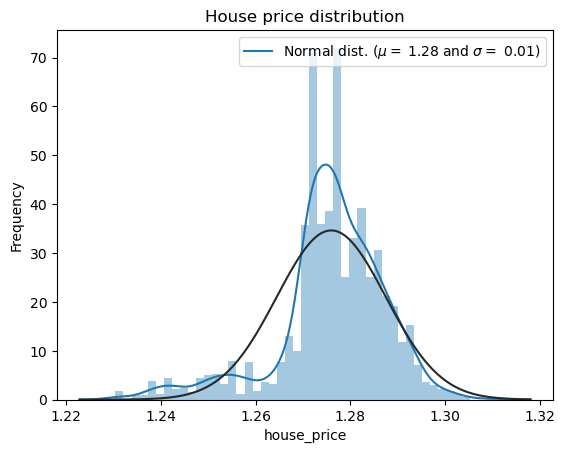

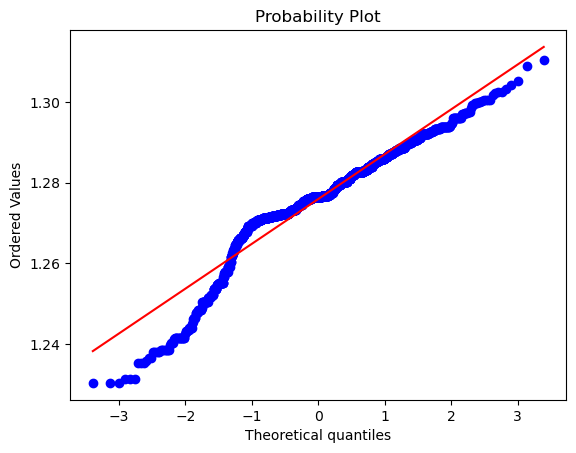

In [130]:
train_df['house_price'] = np.log1p(train_df['house_price'])

# check the new distribution

sns.distplot(train_df['house_price'], fit=norm)

# get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['house_price'])

print(f'\n mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'])
plt.ylabel('Frequency')
plt.title('House price distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['house_price'], plot=plt)
plt.show()